# How to merge orbital rotations in Qiskit circuits

Due to the homomorphism property of [orbital rotations](../explanations/orbital-rotation.ipynb), adjacent orbital rotations occurring in a quantum circuit can be merged into a single orbital rotation, reducing the number of gates that result when the circuit is decomposed into more basic gates.

The following code cell constructs an example of a circuit containing two sequences of consecutive orbital rotations separated by a diagonal Coulomb evolution gate.

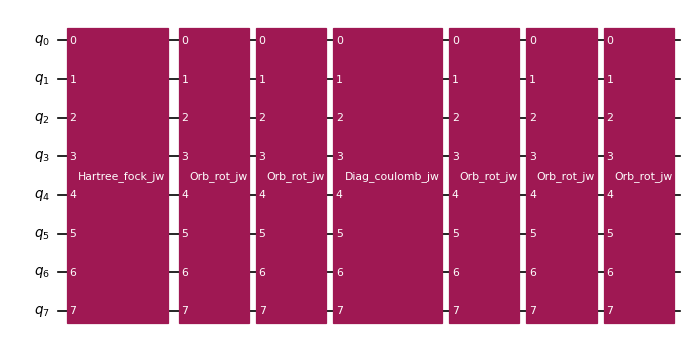

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister

import ffsim

rng = np.random.default_rng(12345)
norb = 4
nelec = (2, 2)

qubits = QuantumRegister(2 * norb, name="q")
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
for _ in range(2):
    circuit.append(
        ffsim.qiskit.OrbitalRotationJW(
            norb, ffsim.random.random_unitary(norb, seed=rng)
        ),
        qubits,
    )
circuit.append(
    ffsim.qiskit.DiagCoulombEvolutionJW(
        norb, ffsim.random.random_real_symmetric_matrix(norb), time=1.0
    ),
    qubits,
)
for _ in range(3):
    circuit.append(
        ffsim.qiskit.OrbitalRotationJW(
            norb, ffsim.random.random_unitary(norb, seed=rng)
        ),
        qubits,
    )

circuit.draw("mpl", scale=0.6)

To merge orbital rotations in the circuit, run the [ffsim.qiskit.PRE_INIT](../api/ffsim.qiskit.rst#ffsim.qiskit.PRE_INIT) pass manager on it. This pass manager contains transpiler passes that decompose higher-level gates into orbital rotations and then merges them.

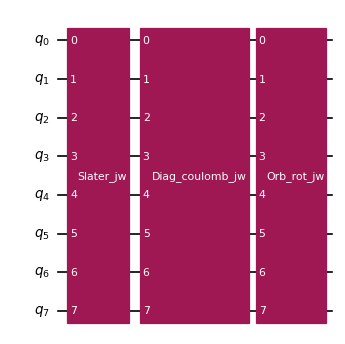

In [2]:
transpiled = ffsim.qiskit.PRE_INIT.run(circuit)
transpiled.draw("mpl", scale=0.6)

Notice that the first sequence of orbital rotations got merged with the Hartree-Fock state preparation gate to produce a Slater determinant preparation gate, which provides a more optimized gate decomposition (see [*Orbital Rotations*](../explanations/orbital-rotation.ipynb#quantum-circuit-implementation)).

The `ffsim.qiskit.PRE_INIT` pass manager is so named because it can be set as the `pre_init` stage of a Qiskit staged pass manager. The following code cell demonstrates a typical transpilation workflow in Qiskit that uses the `ffsim.qiskit.PRE_INIT` pass manager to ensure that orbital rotations are merged.

In [3]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Initialize quantum device backend
backend = GenericBackendV2(2 * norb, basis_gates=["cp", "xx_plus_yy", "p", "x"])

# Create a pass manager for circuit transpilation
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

# Set the pre-initialization stage of the pass manager with passes suggested by ffsim
pass_manager.pre_init = ffsim.qiskit.PRE_INIT

# Transpile the circuit
transpiled = pass_manager.run(circuit)

transpiled.count_ops()

OrderedDict([('cp', 28), ('xx_plus_yy', 20), ('p', 16), ('x', 4)])

Without setting the `pre_init` stage of the pass manager, the number of XXPlusYYGates would be much higher.

In [4]:
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled = pass_manager.run(circuit)

transpiled.count_ops()

OrderedDict([('xx_plus_yy', 60), ('p', 40), ('cp', 28), ('x', 4)])